# Scene Text Detection and Recognition

This notebook is made by

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

FOLDERNAME = "Unbowed, Unbent, Unbroken"

%cd /content/drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Unbowed, Unbent, Unbroken


In [ ]:
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as TF
from torchvision import models, datasets
from torchvision import tv_tensors
import timm

from tqdm.notebook import tqdm

import einops
import numpy as np
from matplotlib import pyplot as plt
from random import randint

import json
from PIL import Image, ImageDraw
import cv2

from itertools import product

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Part 1: Loading Dataset

In [ ]:
# Path to the image directory.
IMAGE_DIR_PATH = 'hiertext'

# Path to the annotation directory.
ANN_DIR_PATH = 'hiertext/gt'

# Path to directory subset images
TRAIN_PATH = os.path.join(ANN_DIR_PATH, 'train.jsonl')
VAL_PATH = os.path.join(ANN_DIR_PATH, 'validation.jsonl')
TEST_PATH = os.path.join(ANN_DIR_PATH, 'test.jsonl')

In [ ]:
train_set = json.load(open(TRAIN_PATH, 'r'))['annotations']
val_set = json.load(open(VAL_PATH, 'r'))['annotations']
test_set = json.load(open(TEST_PATH, 'r'))['annotations']

train_images = [train['image_id'] for train in train_set]
val_images = [val['image_id'] for val in val_set]
test_images = [test['image_id'] for test in test_set]

print(f'{len(train_images)} Train samples loaded.')
print(f'{len(val_images)} Validation samples loaded.')
print(f'{len(test_images)} Test samples loaded.')

8281 Train samples loaded.
1724 Validation samples loaded.
1634 Test samples loaded.


In [ ]:
def draw_mask(vertices, w, h):
    mask = np.zeros((h, w, 3), dtype=np.float32)
    mask = cv2.fillPoly(mask, [vertices], [1.] * 3)[:, :, 0]
    return mask

def stack_word_masks(mask, word_mask):
    return (mask + word_mask > 0.).astype(np.float32)

def load_img(image_id, subset):
    image_path = os.path.join(IMAGE_DIR_PATH, subset, f'{image_id}.jpg')
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def parse_annotation_dict(ann, subset):
    image_id = ann['image_id']
    image = load_img(image_id, subset)
    w = ann['image_width']
    h = ann['image_height']

    gt_word_masks = []
    gt_word_weights = []
    gt_word_texts = []

    gt_line_masks = []
    gt_line_weights = []
    gt_line_texts = []

    gt_paragraph_masks = []
    gt_paragraph_weights = []

    for paragraph in ann['paragraphs']:
      gt_paragraph_mask = np.zeros((h, w), dtype=np.float32)
      for line in paragraph['lines']:
        gt_line_mask = np.zeros((h, w), dtype=np.float32)
        for word in line['words']:
          gt_word_weights.append(1.0 if word['legible'] else 0.0)
          gt_word_texts.append(word['text'])
          vertices = np.array(word['vertices'])
          gt_word_mask = draw_mask(vertices, w, h)
          gt_word_masks.append(gt_word_mask)
          gt_line_mask = stack_word_masks(gt_line_mask, gt_word_mask)
          gt_paragraph_mask = stack_word_masks(gt_paragraph_mask,
                                              gt_word_mask)
        gt_line_masks.append(gt_line_mask)
        gt_line_weights.append(1.0 if line['legible'] else 0.0)
        gt_line_texts.append(line['text'])
      if not paragraph['legible']:
        gt_paragraph_mask = draw_mask(np.array(paragraph['vertices']), w, h)
      gt_paragraph_masks.append(gt_paragraph_mask)
      gt_paragraph_weights.append(1.0 if paragraph['legible'] else 0.0)

    num_gt_words = len(gt_word_masks)
    word_dict = {
        'gt_weights': (np.array(gt_word_weights) if num_gt_words else np.zeros(
            (0,), np.float32)),
        'gt_masks': (np.stack(gt_word_masks, -1) if num_gt_words else np.zeros(
            ((h + 1) // 2, (w + 1) // 2, 0), np.float32)),
        'gt_texts': (np.array(gt_word_texts) if num_gt_words else np.zeros(
            (0,), str)),
    }

    num_gt_lines = len(gt_line_masks)
    line_dict = {
        'gt_weights': (np.array(gt_line_weights) if num_gt_lines else np.zeros(
            (0,), np.float32)),
        'gt_masks': (np.stack(gt_line_masks, -1) if num_gt_lines else np.zeros(
            ((h + 1) // 2, (w + 1) // 2, 0), np.float32)),
        'gt_texts': (np.array(gt_line_texts) if num_gt_lines else np.zeros(
            (0,), str)),
    }

    num_gt_paragraphs = len(gt_paragraph_masks)
    paragraph_dict = {
        'gt_weights':
            (np.array(gt_paragraph_weights) if num_gt_paragraphs else np.zeros(
                (0,), np.float32)),
        'gt_masks':
            (np.stack(gt_paragraph_masks, -1) if num_gt_paragraphs else np.zeros(
                ((h + 1) // 2, (w + 1) // 2, 0), np.float32)),
    }
    return image, word_dict, line_dict, paragraph_dict

In [ ]:
def visualize(mask, weight):
    h, w, n_mask = mask.shape
    if not n_mask:
      return np.zeros((h, w, 3), np.float32)
    palette = np.random.uniform(0.0, 1., (n_mask, 3))
    colored = np.reshape(np.matmul(
          np.reshape(mask, (-1, n_mask)), palette), (h, w, 3))
    dont_care_mask = (np.reshape(np.matmul(
          np.reshape(mask, (-1, n_mask)),
          np.reshape(1.- weight, (-1, 1))), (h, w, 1)) > 0).astype(np.float32)

    filtered = np.clip(dont_care_mask * 1. + (1. - dont_care_mask) * colored, 0., 1.)

    plt.figure(figsize=(15, 15))
    plt.imshow(filtered)
    plt.axis('off')
    plt.show()


In [ ]:
class HierTextDataset(Dataset):
    def __init__(self, dataset, subset, transform=None):
        self.dataset = dataset
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        ann = self.dataset[idx]
        image, word_dict, line_dict, para_dict = parse_annotation_dict(ann, self.subset)

        image_tensor = torch.from_numpy(image).permute(2, 0, 1)
        word_dict['gt_masks'] = torch.from_numpy(word_dict['gt_masks']).permute(2, 0, 1)
        line_dict['gt_masks'] = torch.from_numpy(line_dict['gt_masks']).permute(2, 0, 1)
        para_dict['gt_masks'] = torch.from_numpy(para_dict['gt_masks']).permute(2, 0, 1)

        if self.transform:
            image_tensor, word_dict['gt_masks'] = self.transform(image, word_dict['gt_masks'])
            _, line_dict['gt_masks'] = self.transform(image, line_dict['gt_masks'])
            _, para_dict['gt_masks'] = self.transform(image, para_dict['gt_masks'])

        return {
            'image': image_tensor,
            'word_level': word_dict,
            'line_level': line_dict,
            'para_level': para_dict,
        }

In [ ]:
image_size = 640

train_transform = T.Compose([
    T.Resize((image_size, image_size), antialias=True),
])

valid_transform = T.Compose([
    T.Resize((image_size, image_size), antialias=True),
])

train_dataset = HierTextDataset(train_set, "train")
val_dataset = HierTextDataset(val_set, "validation")
test_dataset = HierTextDataset(test_set, "test")

### Visualize Sample Data

Data description: 

Annotations:  dict_keys(['image', 'word_level', 'line_level', 'para_level'])
Sample Image shape: torch.Size([3, 1195, 1600])
Sample image: 



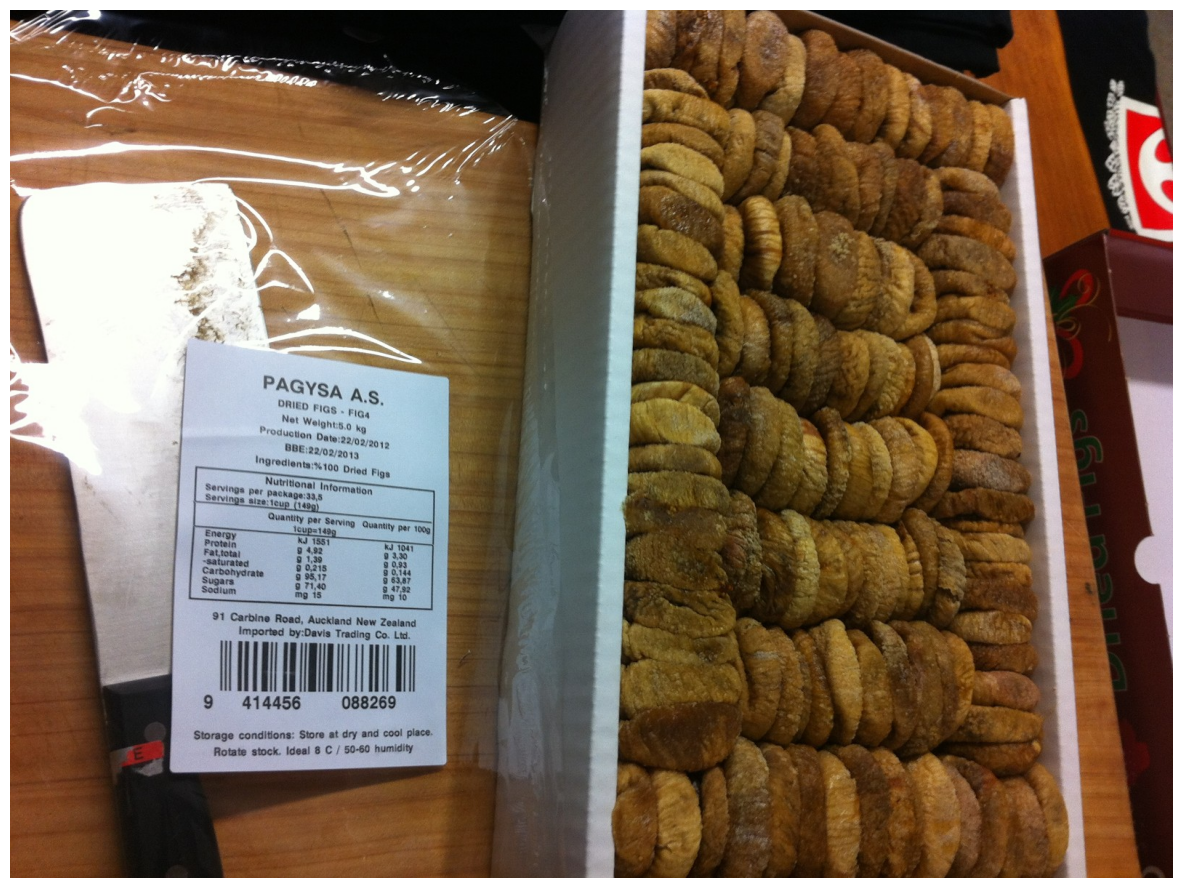

In [ ]:
data = train_dataset[4]

print("Data description: \n")
print("Annotations: ", data.keys())
print("Sample Image shape:", data['image'].shape)
print("Sample image: \n")

plt.figure(figsize=(15, 15))
plt.imshow(data['image'].permute(1, 2, 0))
plt.axis('off')
plt.show()

Word level annotations: 

torch.Size([94, 1195, 1600])
['PAGYSA' 'A.S.' 'Ingredients:%100' 'Dried' 'Figs' 'Production'
 'Date:22/02/2012' 'Net' 'Weight:5.0' 'kg' 'DRIED' 'FIGS' 'FIG4'
 'BBE:22/02/2013' 'Nutritional' 'Information' 'Servings' 'per'
 'package:33,5' 'Servings' 'size:1cup' '(149g)' 'Quantity' 'per' 'Serving'
 'Quantity' 'per' '100g' '1cup=149g' '91' 'Carbine' 'Road,' 'Auckland'
 'New' 'Zealand' 'Imported' 'by:Davis' 'Trading' 'Co.' 'Ltd.' '9' '414456'
 '088269' 'Storage' 'conditions:' 'Store' 'at' 'dry' 'and' 'cool' 'place.'
 'Rotate' 'stock.' 'Ideal' '8' 'C' '50-60' 'humidity' 'Energy' 'kJ' '1551'
 'kJ' '1041' 'Protein' 'g' '4,92' 'g' '3,30' 'Fat,total' 'g' '1,39' 'g'
 '0,93' '-saturated' 'g' '0,215' 'g' '0,144' 'Carbohydrate' 'g' '95,17'
 'g' '63,87' 'Sugars' 'g' '71,40' 'g' '47,92' 'Sodium' 'mg' '15' 'mg' '10'
 '']


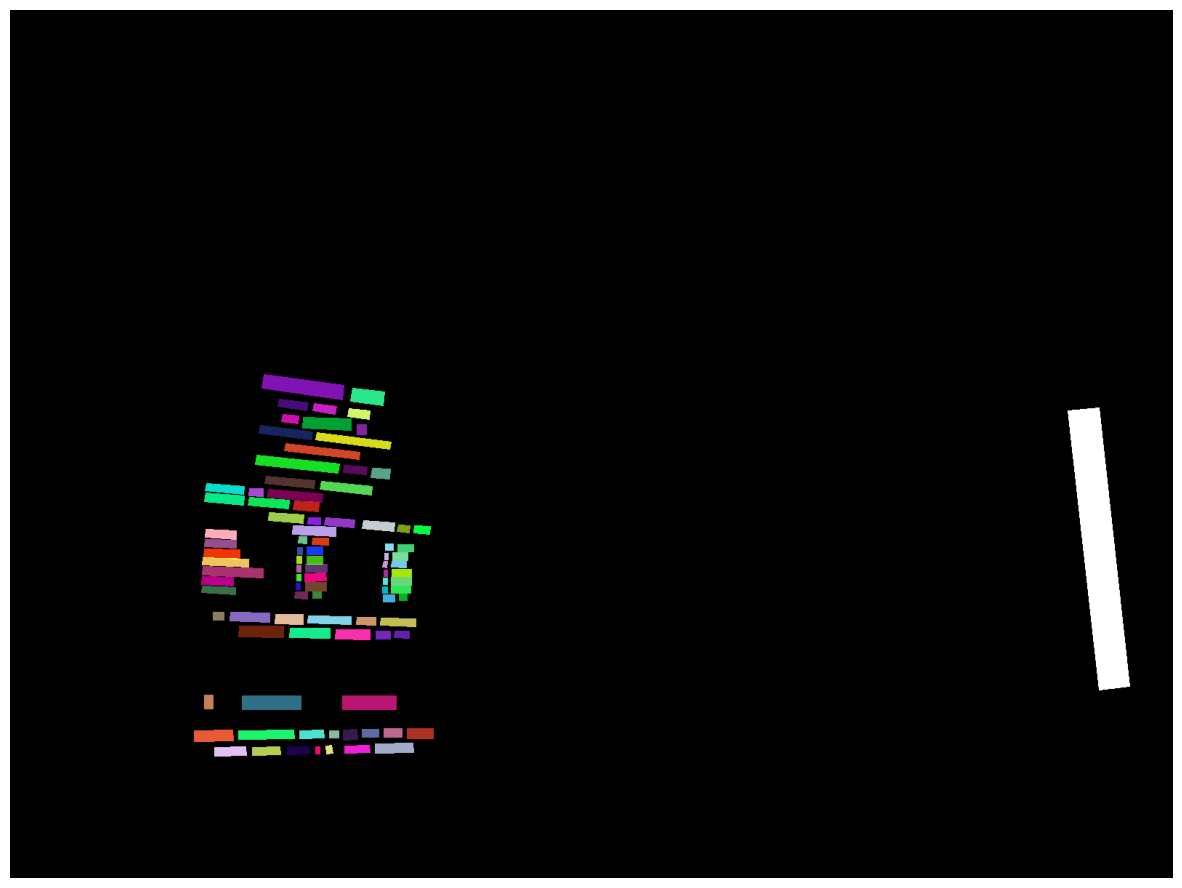

In [ ]:
print("Word level annotations: \n")
print(data['word_level']['gt_masks'].shape)
print(data['word_level']['gt_texts'])

visualize(torch.Tensor.numpy(data['word_level']['gt_masks'].permute(1, 2, 0)), data['word_level']['gt_weights'])

Line level annotations: 

torch.Size([38, 1195, 1600])
['PAGYSA A.S.' 'Ingredients:%100 Dried Figs' 'Production Date:22/02/2012'
 'Net Weight:5.0 kg' 'DRIED FIGS FIG4' 'BBE:22/02/2013'
 'Nutritional Information' 'Servings per package:33,5'
 'Servings size:1cup (149g)' 'Quantity per Serving Quantity per 100g'
 '1cup=149g' '91 Carbine Road, Auckland New Zealand'
 'Imported by:Davis Trading Co. Ltd.' '9 414456 088269'
 'Storage conditions: Store at dry and cool place.'
 'Rotate stock. Ideal 8 C 50-60 humidity' 'Energy' 'kJ 1551' 'kJ 1041'
 'Protein' 'g 4,92' 'g 3,30' 'Fat,total' 'g 1,39' 'g 0,93' '-saturated'
 'g 0,215' 'g 0,144' 'Carbohydrate' 'g 95,17' 'g 63,87' 'Sugars' 'g 71,40'
 'g 47,92' 'Sodium' 'mg 15' 'mg 10' '']


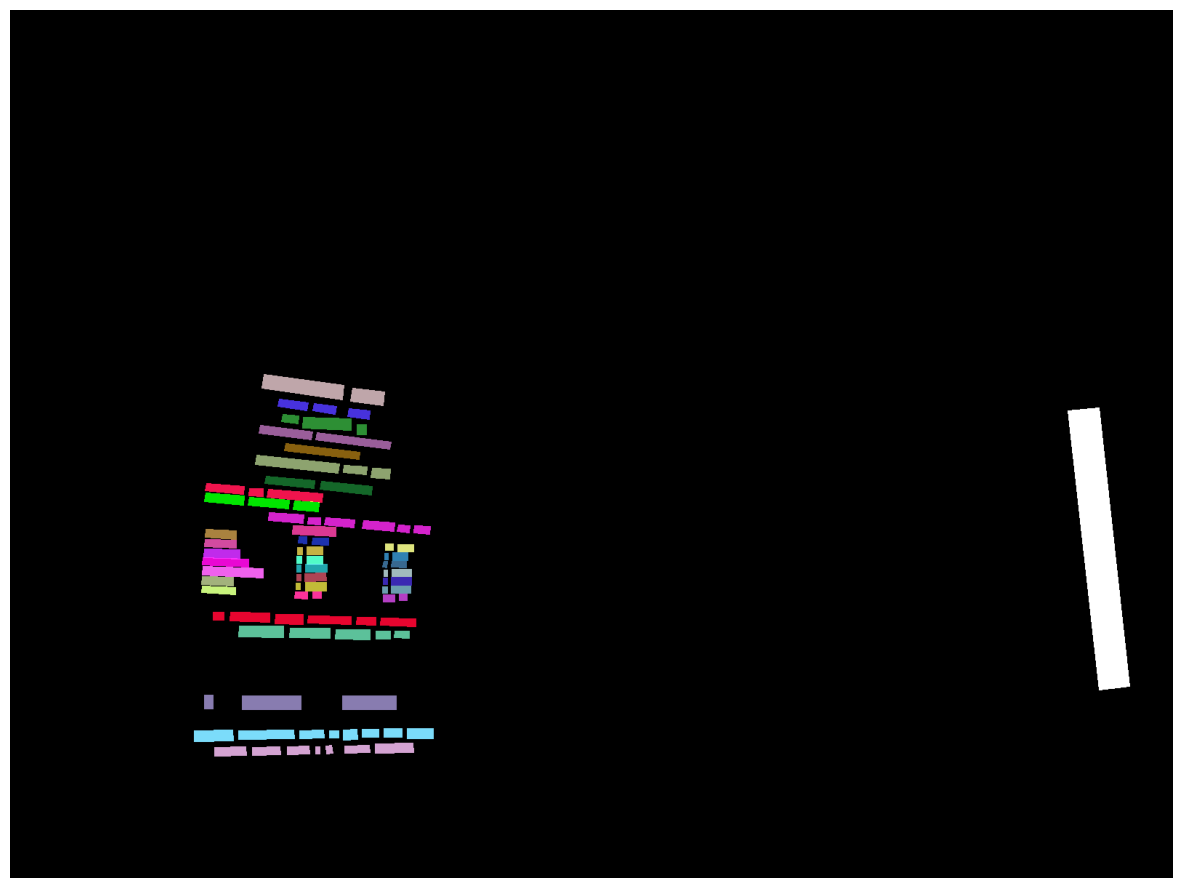

In [ ]:
print("Line level annotations: \n")
print(data['line_level']['gt_masks'].shape)
print(data['line_level']['gt_texts'])

visualize(torch.Tensor.numpy(data['line_level']['gt_masks'].permute(1, 2, 0)), data['line_level']['gt_weights'])

Paragraph level annotations: 

torch.Size([32, 1195, 1600])


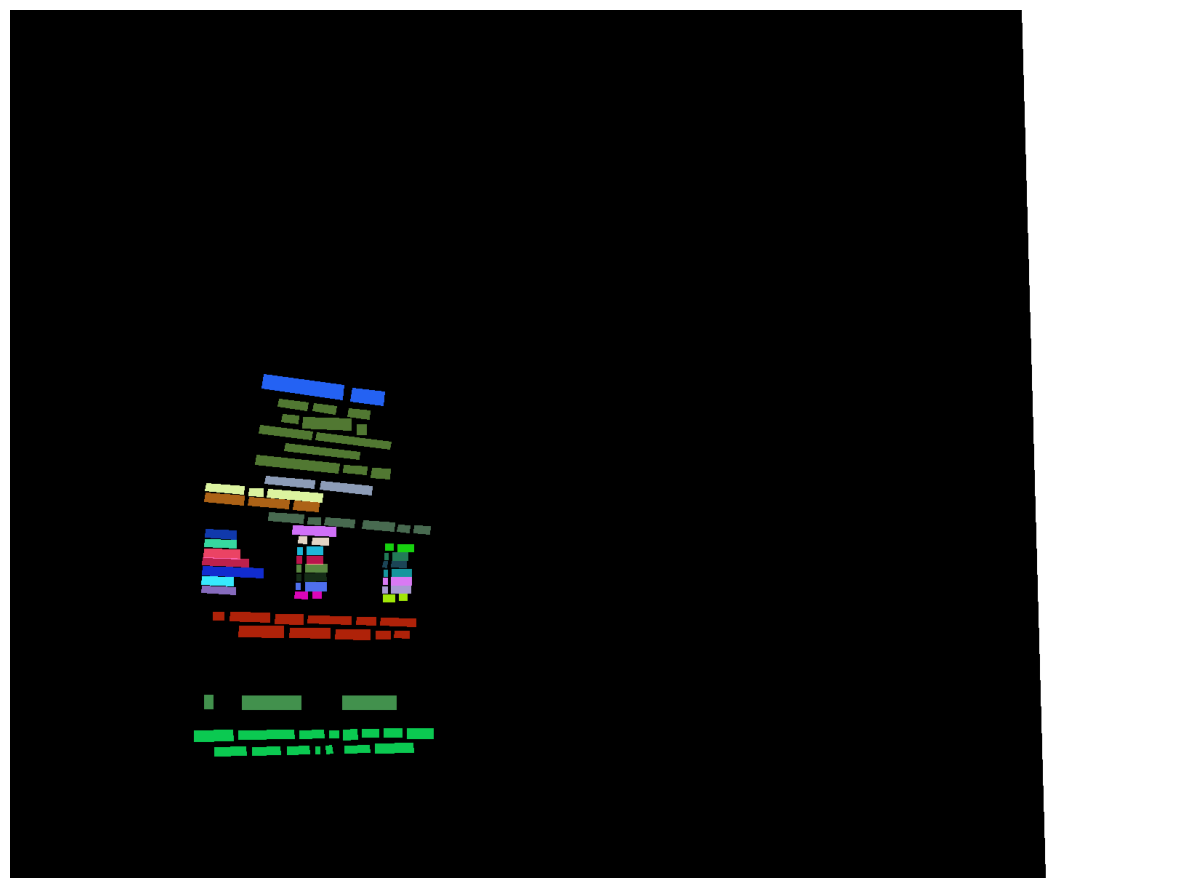

In [ ]:
print("Paragraph level annotations: \n")
print(data['para_level']['gt_masks'].shape)

visualize(torch.Tensor.numpy(data['para_level']['gt_masks'].permute(1, 2, 0)), data['para_level']['gt_weights'])

## Part 2: LayoutFormer for Scene Text Detection

### Feature Encoder

In [ ]:
backbone = timm.create_model(
    'resnet101',
    pretrained=True,
    features_only=True,
    out_indices=(2, 3, 4)
)

Input feature shapes: {'res2': torch.Size([2, 256, 128, 128]), 'res3': torch.Size([2, 512, 64, 64]), 'res4': torch.Size([2, 1024, 32, 32]), 'res5': torch.Size([2, 2048, 16, 16])}
Output pixel embedding shape: torch.Size([2, 256, 128, 128])


In [ ]:
summary(backbone, (3, 640, 640))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]           9,408
       BatchNorm2d-2         [-1, 64, 320, 320]             128
              ReLU-3         [-1, 64, 320, 320]               0
         MaxPool2d-4         [-1, 64, 160, 160]               0
            Conv2d-5         [-1, 64, 160, 160]           4,096
       BatchNorm2d-6         [-1, 64, 160, 160]             128
              ReLU-7         [-1, 64, 160, 160]               0
            Conv2d-8         [-1, 64, 160, 160]          36,864
       BatchNorm2d-9         [-1, 64, 160, 160]             128
         Identity-10         [-1, 64, 160, 160]               0
             ReLU-11         [-1, 64, 160, 160]               0
         Identity-12         [-1, 64, 160, 160]               0
           Conv2d-13        [-1, 256, 160, 160]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [ ]:
dummy_input = torch.randn(2, 3, 640, 640) # Batch size 2

with torch.no_grad():
    outputs = backbone(dummy_input)

print("\n--- Output Shapes ---")
for value in outputs:
    if value is not None:
        print(f"{value.shape}")


--- Output Shapes ---
torch.Size([2, 512, 80, 80])
torch.Size([2, 1024, 40, 40])
torch.Size([2, 2048, 20, 20])


In [ ]:
class FeatureEncoder(nn.Module):
      def __init__(self, backbone, multiscale_fm_channel):
          super().__init__()
          self.backbone = backbone
          self.multiscale_fm_conv1 = nn.Conv2d(in_channels=512,
                                             out_channels=multiscale_fm_channel,
                                             kernel_size=(1,1),
                                             stride=(1,1))
          self.multiscale_fm_conv2 = nn.Conv2d(in_channels=1024,
                                             out_channels=multiscale_fm_channel,
                                             kernel_size=(1,1),
                                             stride=(1,1))
          self.multiscale_fm_conv3 = nn.Conv2d(in_channels=2048,
                                             out_channels=multiscale_fm_channel,
                                             kernel_size=(1,1),
                                             stride=(1,1))
          self.multiscale_fm_conv4 = nn.Conv2d(in_channels=2048,
                                             out_channels=multiscale_fm_channel,
                                             kernel_size=(1,1),
                                             stride=(2,2))
      def forward(self, x):
          x = self.backbone(x)
          c1 = self.multiscale_fm_conv1(x[0])
          c2 = self.multiscale_fm_conv2(x[1])
          c3 = self.multiscale_fm_conv3(x[2])
          c4 = self.multiscale_fm_conv4(x[2])

          return {
              'C1': c1,
              'C2': c2,
              'C3': c3,
              'C4': c4
          }

In [ ]:
dummy_input = torch.randn(2, 3, 640, 640) # Batch size 2

model = FeatureEncoder(backbone, 256)

with torch.no_grad():
    outputs = model(dummy_input)

print("\n--- Output Shapes ---")
for key, value in outputs.items():
    if value is not None:
        print(f"{key}, {value.shape}")


--- Output Shapes ---
C1, torch.Size([2, 256, 80, 80])
C2, torch.Size([2, 256, 40, 40])
C3, torch.Size([2, 256, 20, 20])
C4, torch.Size([2, 256, 10, 10])


### Prior Location Sampler

In [ ]:
class PriorLocationSampler(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

### Transformer Decoder

In [ ]:
class WordDecoder(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):

        return x

class LineDecoder(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):

        return x

class ParaDecoder(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):

        return x

### LayoutFormer

In [ ]:
class LayoutFormer(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.feature_encoder = FeatureEncoder(backbone)

    def forward(self, x):

        return x

### Objective Function

The objective function we use to train LayoutFormer follows the objective used in the original paper. The objective function  account multi-level supervision and is defined as follows:


$$
\begin{aligned}
l = l_{\text{word}} + l_{\text{line}} + l_{\text{para}}
\end{aligned}
$$

where,

* $l_{\text{word}}$ is the objective function to supervise the word-level text detection task.
* $l_{\text{line}}$ is the objective function to supervise the line-level text detection task.
* $l_{\text{para}}$ is the objective function to supervise the para-level text detection task.

Where each level task is formulated as:

$$
\begin{aligned}
L = \lambda_{\text{cls}}L_{\text{cls}}(P_*, P'_*) + \lambda_{\text{mask}}L_{\text{mask}}(M_*, M'_*)
\end{aligned}
$$

where
* $L_{\text{cls}}$ is the cross-entropy loss of prediction class $P_*$ and ground truth class $P'_*$
* $L_{\text{mask}}$ is the sum of cross-entropy loss and dice loss of prediction mask $M_*$ and ground truth mask $M'_*$
* $\lambda_{\text{cls}}$  and $\lambda_{\text{mask}}$ are weight to the $L_{\text{cls}}$ and $L_{\text{mask}}$ respectively.


In [ ]:
class LayoutFormerLoss(nn.Module):
      def __init__(self, preds, labels, lambda_cls = 2, lambda_mask = 5):
          super().__init__()
          self.lambda_cls = lambda_cls
          self.lambda_mask = lambda_mask
          self.ce_loss = nn.nn.CrossEntropyLoss()

      def dice_loss(self, preds, labels):
          prob_preds = F.softmax(preds, dim=1)
          dice_coeff = (2. * torch.sum(prob_preds * labels)) / (torch.sum(prob_preds) + torch.sum(labels))
          return 1. - dice_coeff

      def loss_mask(self, preds, labels):
          ce_loss = self.ce_loss(preds, labels)
          dice_loss = self.dice_loss(preds, labels)
          return ce_loss + dice_loss

      def single_level_loss(self, preds, labels):
          loss_cls = self.ce_loss(preds, labels)
          loss_mask = self.loss_mask(preds, labels)
          return self.lambda_cls * loss_cls + self.lambda_mask * loss_mask, loss_cls, loss_mask

      def forward(self, preds, labels):
          loss_cls = self.ce_loss(preds, labels)
          loss_mask = self.ce_loss(preds, labels)
          return self.lambda_cls * loss_cls + self.lambda_mask * loss_mask, loss_cls, loss_mask

### Training and Evaluation

In [ ]:
def eval(model, criterion, loader):
    total_overall_loss = 0
    total_class_loss = 0
    total_local_loss = 0
    total_conf_loss = 0

    model = model.to(device)
    model.eval()

    with torch.no_grad():
        for imgs, labels in tqdm(loader, leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            overall_loss, class_loss, local_loss, conf_loss = criterion(outputs, labels)
            total_overall_loss += overall_loss.item()
            total_class_loss += class_loss.item()
            total_local_loss += local_loss.item()
            total_conf_loss += conf_loss.item()
    total_items = len(loader.dataset)
    return total_overall_loss / total_items, total_class_loss / total_items, total_local_loss / total_items, total_conf_loss / total_items


def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, path=None, scheduler=None):
    print('beginning to train model')
    if path and not os.path.exists(path):
        os.makedirs(path)

    model = model.to(device)

    best_val_loss = float('inf')

    for epoch in tqdm(range(1, num_epochs + 1)):
        model.train()
        total_overall_loss = 0
        total_class_loss = 0
        total_local_loss = 0
        total_conf_loss = 0
        start_time = time.perf_counter()

        for i, (inputs, labels) in enumerate(tqdm(train_loader, leave=False)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            overall_loss, class_loss, local_loss, conf_loss = criterion(outputs, labels)
            overall_loss.backward()
            optimizer.step()
            total_overall_loss += overall_loss.item()
            total_class_loss += class_loss.item()
            total_local_loss += local_loss.item()
            total_conf_loss += conf_loss.item()

        if path:
            torch.save(model.state_dict(), f'{path}/model_ep_{epoch:02d}.pth')

        end_time = time.perf_counter()
        duration = end_time - start_time

        total_items = len(train_loader.dataset)
        train_overall_loss = total_overall_loss / total_items
        train_class_loss = total_class_loss / total_items
        train_local_loss = total_local_loss / total_items
        train_conf_loss = total_conf_loss / total_items
        valid_overall_loss, valid_class_loss, valid_local_loss, valid_conf_loss = eval(model, criterion, val_loader)

        if valid_overall_loss < best_val_loss:
            best_val_loss = valid_overall_loss
            if path:
                torch.save(model.state_dict(), f'{path}/best_model.pth')

        current_lr = optimizer.param_groups[0]['lr']

        if scheduler and current_lr > 1e-4:
            scheduler.step()

        print(f'epoch {epoch:2}',
              f'time: {duration:.3f}',
              f'lr: {current_lr:.3e}',
              '\n',
              f'train loss (overall): {train_overall_loss:08.4f}',
              f'valid loss (overall): {valid_overall_loss:08.4f}',
              '\n',
              f'train loss (class):   {train_class_loss:08.4f}',
              f'valid loss (class):   {valid_class_loss:08.4f}',
              '\n',
              f'train loss (local):   {train_local_loss:08.4f}',
              f'valid loss (local):   {valid_local_loss:08.4f}',
              '\n',
              f'train loss (conf):    {train_conf_loss:08.4f}',
              f'valid loss (conf):    {valid_conf_loss:08.4f}')

In [ ]:
layoutformer = LayoutFormer(resnet, resnet_channels)
layoutformer = layoutformer.to(device)
summary(layoutformer, (640, 640, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
batch_size = 4

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

In [ ]:
num_epochs = 30
criterion = layoutformer_loss
optimizer = optim.AdamW(layoutformer.parameters(), lr=1e-4, weight_decay=1e-2)

In [ ]:
train(layoutformer, train_loader, val_loader, num_epochs, criterion, optimizer, 'checkpoints_layoutformer')

## Part 3: Permuted Autoregressive Sequence Model for Scene Text Recognition

## Part 4: Put All of It Together

## Part 5: Evaluation

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)